In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import time
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from einops import rearrange
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from typing import Any
import wandb
import multiprocessing
import matplotlib.pyplot as plt

# TransPath Model architecture

![architecture](./images/architecture.png)

## ResNet Block

In [2]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, dropout=0.1):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels

        self.norm1 = nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)
        self.norm2 = nn.GroupNorm(num_groups=32, num_channels=out_channels, eps=1e-6, affine=True)

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.dropout = nn.Dropout(dropout)
        self.silu = nn.SiLU()
        self.idConv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=1,
        )

    def forward(self, x):
        h = x

        h = self.norm1(h)
        h = self.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = self.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        x = self.idConv(x)

        return x + h

## Encoder

In [3]:
class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=0.5, mode="nearest")
        x = self.conv(x)
        return x

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, downsample_steps, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(
                in_channels, 
                hidden_channels, 
                kernel_size=5, 
                stride=1, 
                padding=2
            )
        ])
        for _ in range(downsample_steps):
            self.layers.append(
                nn.Sequential(
                    ResNetBlock(hidden_channels, hidden_channels, dropout),
                    Downsample(hidden_channels)
                )
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Decoder

In [5]:
class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels, upsample_steps, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(upsample_steps):
            self.layers.append(
                nn.Sequential(
                    ResNetBlock(hidden_channels, hidden_channels, dropout),
                    Upsample(hidden_channels)
                )
            )
        self.norm = nn.GroupNorm(num_groups=32, num_channels=hidden_channels, eps=1e-6, affine=True)
        self.silu = nn.SiLU()
        self.conv_out = nn.Conv2d(
            hidden_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        x = self.silu(x)
        x = self.conv_out(x)
        return torch.tanh(x)

## Positional Embedings

In [7]:
def build_grid(resolution, max_v=1.):
    """
    :param resolution: tuple of 2 numbers
    :return: grid for positional embeddings built on input resolution
    """
    ranges = [np.linspace(0., max_v, num=res) for res in resolution]
    grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
    grid = np.stack(grid, axis=-1)
    grid = np.reshape(grid, [resolution[0], resolution[1], -1])
    grid = np.expand_dims(grid, axis=0)
    grid = grid.astype(np.float32)
    return np.concatenate([grid, max_v - grid], axis=-1)

In [8]:
class PosEmbeds(nn.Module):
    def __init__(self, hidden_size, resolution):
        super().__init__()
        self.linear = nn.Linear(4, hidden_size)
        self.grid = nn.Parameter(Tensor(build_grid(resolution)), requires_grad=False)
        
    def forward(self, inputs):
        pos_emb = self.linear(self.grid).moveaxis(3, 1)
        return inputs + pos_emb
    
    def change_resolution(self, resolution, max_v):
        self.grid = nn.Parameter(Tensor(build_grid(resolution, max_v)), requires_grad=False)

## FeedForward Layer

In [9]:
class FeedForward(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=None, dropout=0.2):
        super().__init__()
        out_channels = in_channels if out_channels is None else out_channels

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## Transformer Block

In [10]:
class BasicTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.3, context_dim=None):
        super().__init__()
        
        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, kdim=context_dim, vdim=context_dim, batch_first=True)
        self.ff = FeedForward(embed_dim, embed_dim * 4, dropout=dropout)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, context=None):
        h1 = self.norm1(x)
        h1, _ = self.attn1(h1, h1, h1, need_weights=False)
        x = h1 + x
        
        h2 = self.norm2(x)
        context = h2 if context is None else context
        h2, _ = self.attn2(h2, context, context, need_weights=False)
        x = h2 + x

        h3 = self.norm3(x)
        x = self.ff(h3) + x

        return x

In [11]:
class SpatialTransformer(nn.Module):
    """
    Transformer block for image-like data.
    First, project the input (aka embedding)
    and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image
    """
    def __init__(self, in_channels, num_heads,
                 depth=4, dropout=0.3, context_dim=None):
        super().__init__()
        self.in_channels = in_channels
        
        self.norm = nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)
        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(in_channels, num_heads, dropout=dropout, context_dim=context_dim)
                for d in range(depth)]
        )

    def forward(self, x, context=None):
        # note: if no context is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        f = x
        f = self.norm(f)
        f = rearrange(f, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            f = block(f, context=context)
        f = rearrange(f, 'b (h w) c -> b c h w', h=h, w=w)
        return f + x

# TransPath Model

In [12]:
class TransPathModel(nn.Module):
    def __init__(self, 
                in_channels=2, 
                out_channels=1, 
                hidden_channels=64,
                attn_blocks=4,
                attn_heads=4,
                cnn_dropout=0.15,
                attn_dropout=0.15,
                downsample_steps=3, 
                resolution=(64, 64)):
        super().__init__()
        
        self.encoder = Encoder(in_channels, hidden_channels, downsample_steps, cnn_dropout)
        self.decoder = Decoder(hidden_channels, out_channels, downsample_steps, cnn_dropout)
        
        self.encoder_pos = PosEmbeds(
            hidden_channels, 
            (resolution[0] // 2**downsample_steps, resolution[1] // 2**downsample_steps)
        )
        self.decoder_pos = PosEmbeds(
            hidden_channels, 
            (resolution[0] // 2**downsample_steps, resolution[1] // 2**downsample_steps)
        )

        self.transformer = SpatialTransformer(
            hidden_channels, 
            attn_heads,
            attn_blocks, 
            attn_dropout
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.encoder_pos(x)
        x = self.transformer(x)
        x = self.decoder_pos(x)
        x = self.decoder(x)
        return x

## Training Module

In [13]:
class TransPathLit(L.LightningModule):
    def __init__(self, model: nn.Module, mode: str='f', learning_rate: float=1e-4, weight_decay: float=0.0) -> None:
        super().__init__()
        self.save_hyperparameters()
        
        self.model = model
        self.mode = mode
        self.loss = nn.L1Loss() if mode == 'h' else nn.MSELoss()
        self.k = 64*64 if mode == 'h' else 1
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def training_step(
        self, batch: tuple[Tensor, Tensor, Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        map_design, start, goal, gt_hmap = batch
        inputs = torch.cat([map_design, start + goal], dim=1) if self.mode in ('f', 'nastar') else torch.cat([map_design, goal], dim=1)
        predictions = self.model(inputs)
        loss = self.loss((predictions + 1) / 2 * self.k, gt_hmap)
        self.log(f'train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor, Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        map_design, start, goal, gt_hmap = batch
        inputs = torch.cat([map_design, start + goal], dim=1) if self.mode in ('f', 'nastar') else torch.cat([map_design, goal], dim=1)
        predictions = self.model(inputs)
        loss = self.loss((predictions + 1) / 2 * self.k, gt_hmap)
        self.log(f'val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.learning_rate, total_steps=self.trainer.estimated_stepping_batches
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

In [14]:
class PathLogger(L.Callback):
    def __init__(self, val_batch, num_samples=10, mode='f'):
        super().__init__()
        map_design, start, goal, gt_hmap = val_batch[:num_samples]
        inputs = torch.cat([map_design, start + goal], dim=1) if mode == 'f' else torch.cat([map_design, goal], dim=1)
        self.val_samples = inputs[:num_samples]
        if mode == 'f':
            self.hm = gt_hmap[:num_samples]
        elif mode == 'h':
            self.hm =  (gt_hmap / gt_hmap.amax(dim=(2, 3), keepdim=True))[:num_samples]
        else:
            self.hm = gt_hmap[:num_samples]

    def on_validation_epoch_end(self, trainer, lightning_module):
        val_samples = self.val_samples.to(device=lightning_module.device)
        prediction = (lightning_module.model(val_samples) + 1) / 2
        if lightning_module.mode == 'h':
            prediction = prediction * 64 * 64

        trainer.logger.experiment.log({
            'data': [wandb.Image(x) for x in torch.cat([self.val_samples, self.hm], dim=1)],
            'predictions': [wandb.Image(x) for x in torch.cat([val_samples, prediction], dim=1)]
        })

# Dataset

In [15]:
class GridData(Dataset):
    """
    'mode' argument defines type of ground truth values:
        f - focal values
        h - absolute ideal heuristic values
        cf - correction factor values
    """
    def __init__(self, path, mode='f', clip_value=0.95, img_size=64):
        self.img_size = img_size
        self.clip_v = clip_value
        self.mode = mode

        self.maps   = np.load(os.path.join(path,    'maps.npy'),    mmap_mode='c')
        self.goals  = np.load(os.path.join(path,    'goals.npy'),   mmap_mode='c')
        self.starts = np.load(os.path.join(path,    'starts.npy'),  mmap_mode='c')
        
        file_gt = {'f' : 'focal.npy', 'h':'abs.npy', 'cf': 'cf.npy'}[mode]
        self.gt_values = np.load(os.path.join(path, file_gt), mmap_mode='c')


    def __len__(self):
        return len(self.gt_values)
    
    def __getitem__(self, idx):
        gt_ = torch.from_numpy(self.gt_values[idx].astype('float32'))
        if self.mode == 'f':
            gt_=  torch.where( gt_ >= self.clip_v, gt_ , torch.zeros_like( torch.from_numpy(self.gt_values[idx])))
        return (torch.from_numpy(self.maps[idx].astype('float32')), 
                torch.from_numpy(self.starts[idx].astype('float32')), 
                torch.from_numpy(self.goals[idx].astype('float32')), 
                gt_ )

In [16]:
dataset_dir = './TransPath_AlekSet'
mode = 'cf'
batch_size = 256
max_epochs = 100
learning_rate = 4e-4
weight_decay = 0.0
limit_train_batches = None
limit_val_batches = None
proj_name = 'TransPath_runs'
run_name = 'default'
accelerator = "cuda"
devices = [5]
torch.set_default_device(torch.device(f"cuda:{devices[-1]}"))

In [17]:
train_data = GridData(
        path=f'{dataset_dir}/train',
        mode=mode
    )
val_data = GridData(
        path=f'{dataset_dir}/val',
        mode=mode
    )
resolution = (train_data.img_size, train_data.img_size)

In [18]:
torch.manual_seed(42)
train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size,
        shuffle=True, 
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True,
        generator=torch.Generator(device=f'cuda:{devices[-1]}'),
    )
val_dataloader = DataLoader(
        val_data, 
        batch_size=batch_size,
        shuffle=False, 
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )
samples = next(iter(val_dataloader))

# Training

In [19]:
torch.manual_seed(42)
timestr = time.strftime("%Y%m%d-%H%M%S")
callback = PathLogger(samples, mode=mode, num_samples=20)
checkpoints = ModelCheckpoint(dirpath='checkpoints/', filename='cf-{epoch}-20250126-210000', every_n_epochs=50)
wandb_logger = WandbLogger(project=proj_name, name=f'{run_name}_{mode}', log_model='all')

model_path = './weights/alex_100_cf_model'
model = TransPathModel()
model.load_state_dict(torch.load(model_path, weights_only=True))

lit_module = TransPathLit(
        model=model,
        mode=mode,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

trainer = L.Trainer(
        logger=wandb_logger,
        accelerator=accelerator,
        devices=devices,
        max_epochs=max_epochs,
        deterministic=False,
        limit_train_batches=limit_train_batches,
        limit_val_batches=limit_val_batches,
        callbacks=[callback, checkpoints],
    )

/home/drozdovdan/miniconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(lit_module, train_dataloader, val_dataloader)
wandb.finish()

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: daniil-drozdovjr (daniil-drozdovjr-saint-petersburg-state-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/home/drozdovdan/miniconda3/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/drozdovdan/HS_HW_TransPath/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
Loading `train_dataloader` to estimate number of stepping batches.
/home/drozdovdan/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | TransPathModel | 963 K  | train
1 | loss  | MSELoss        | 0      | train
-------------------------------------------------
962 K     Trainable params
512       Non-trainable params
963 K     Total params
3.854     Total estimated model params size 

Sanity Checking: |                                                                                            …

/home/drozdovdan/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,███▇▇▆▆▆▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,99
train_loss,0.00657
trainer/global_step,49999
val_loss,0.0048


In [ ]:
weights_dir = './weights/'
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model.state_dict(), f'{weights_dir}/model_{timestr}')

# Evaluation

cuda:5 cuda:5


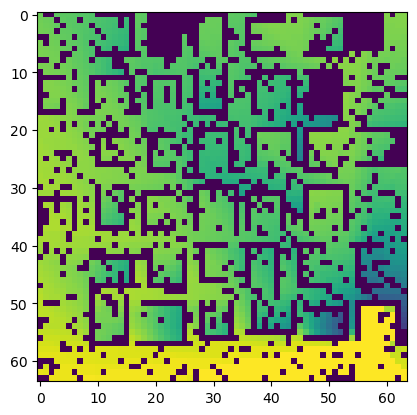

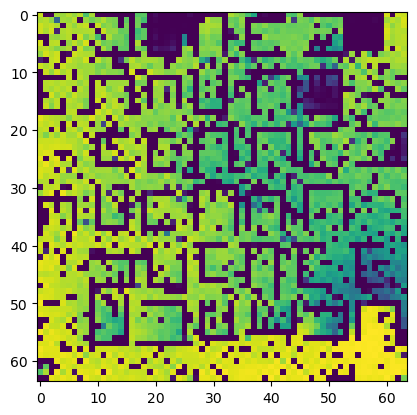

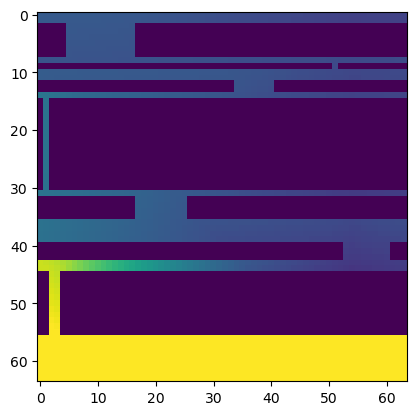

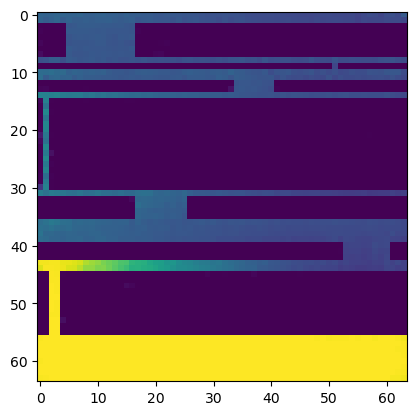

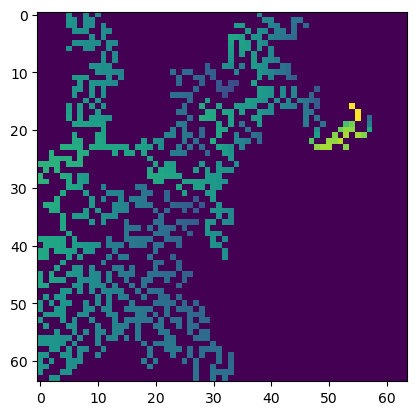

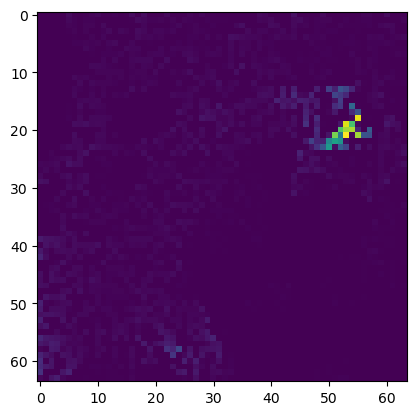

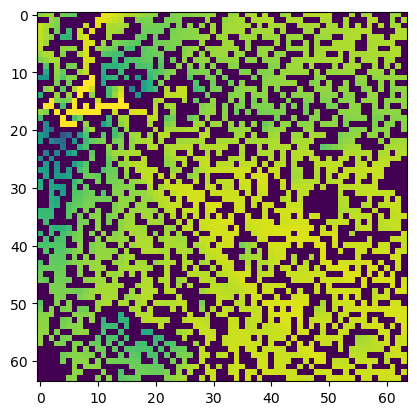

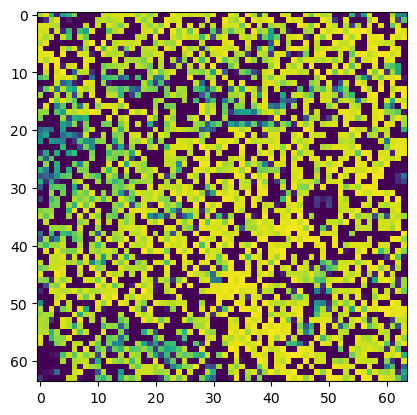

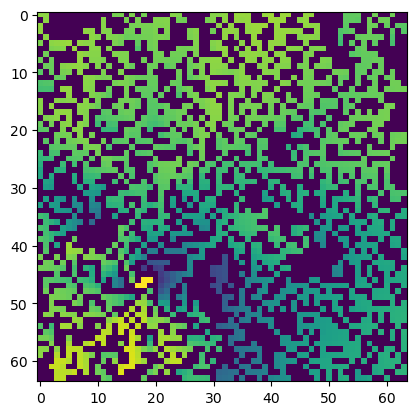

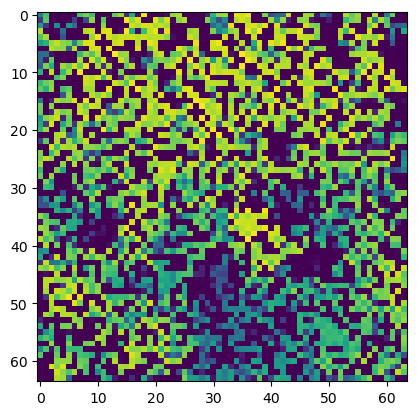

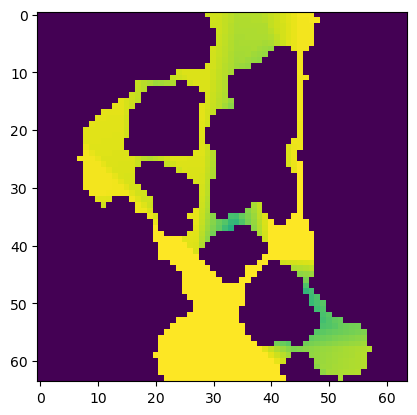

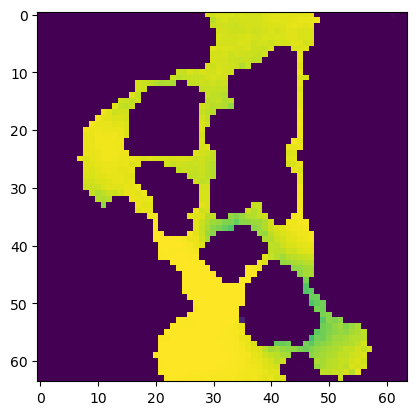

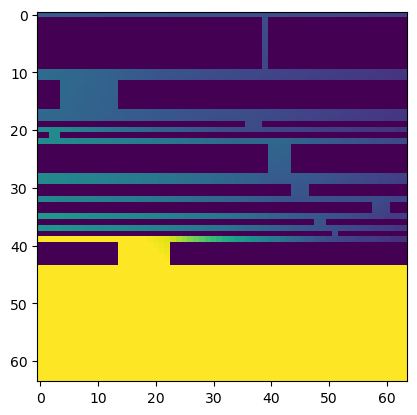

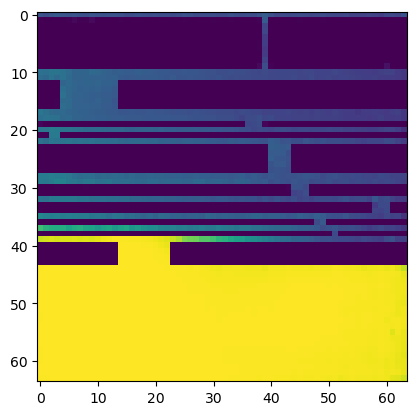

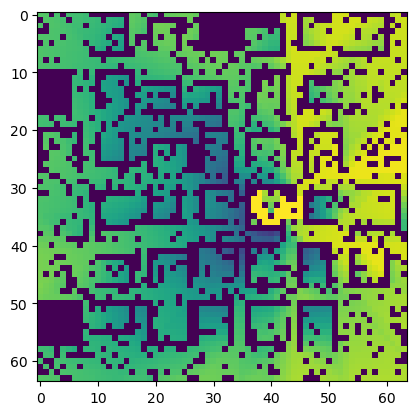

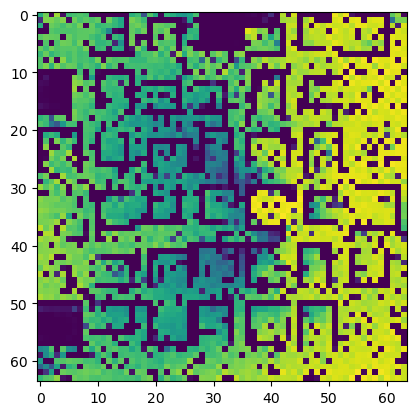

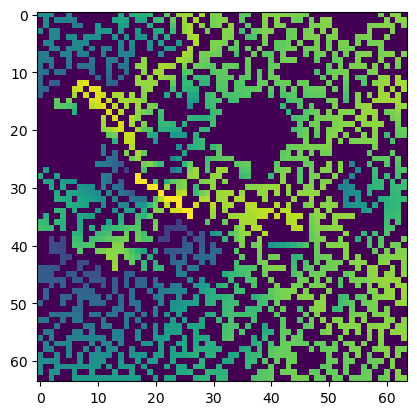

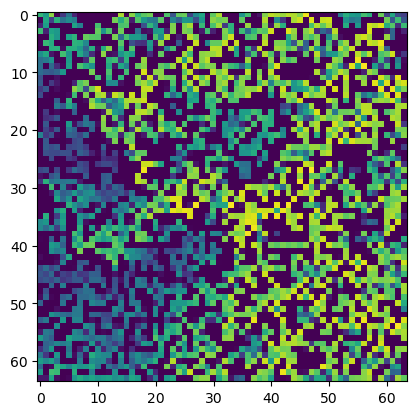

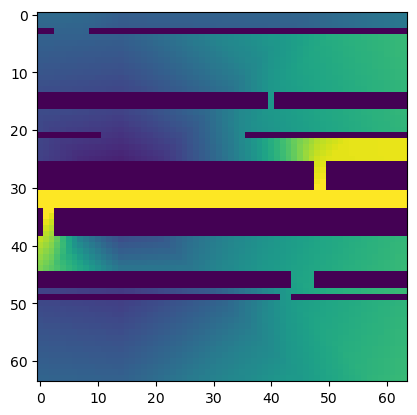

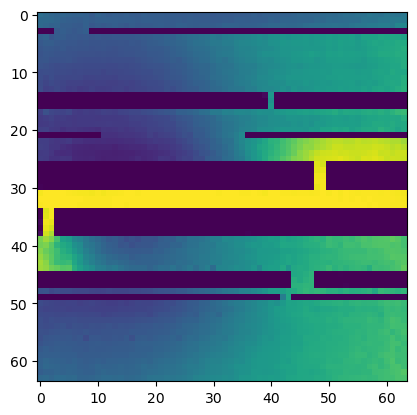

In [22]:
model_path = './weights/alex_200_cf_model'
indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

eval_model = TransPathModel().to(torch.device(f'{accelerator}:{devices[-1]}'))
eval_model.load_state_dict(torch.load(model_path, weights_only=True))
eval_model.eval()

test_data = GridData(
        path=f'{dataset_dir}/test',
        mode=mode
    )[indices]

map_design, start, goal, gt_hmap = test_data
inputs = torch.cat([map_design, start + goal], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goal], dim=1)
inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))
print(inputs.device, f'{accelerator}:{devices[-1]}')
with torch.no_grad():
    predictions = (eval_model(inputs) + 1) / 2
for i in range(len(indices)):
    plt.imshow(gt_hmap[i, 0])
    plt.show()
    plt.imshow(predictions[i, 0].cpu().detach().numpy())
    plt.show()

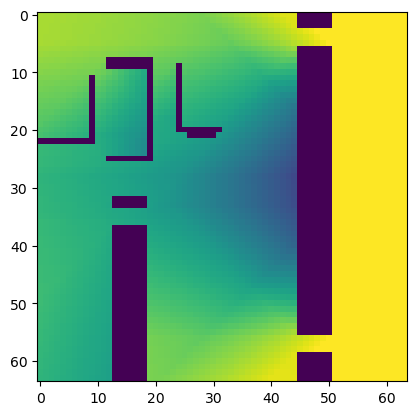

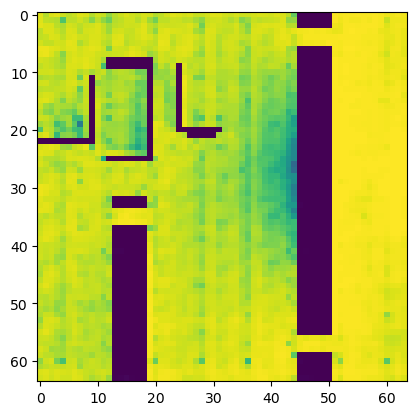

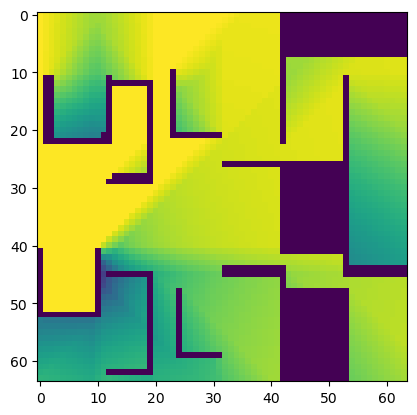

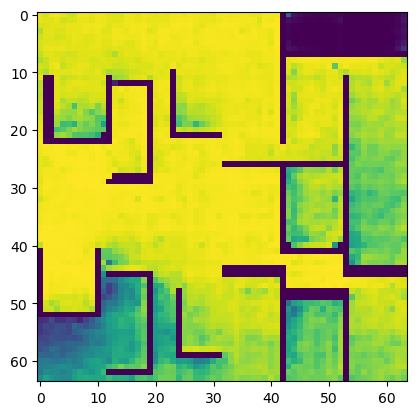

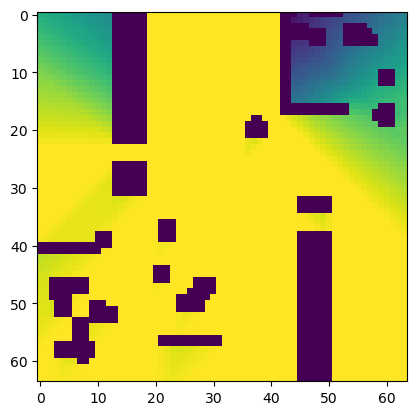

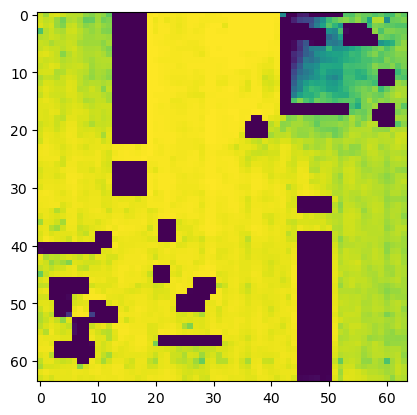

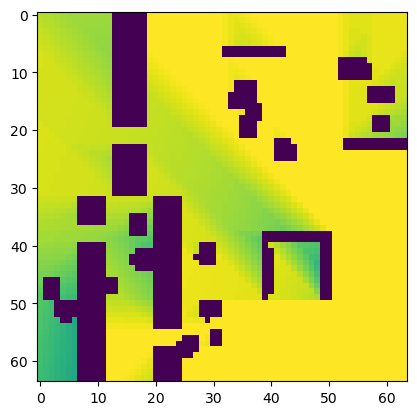

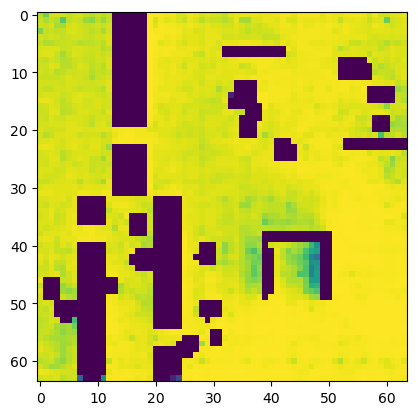

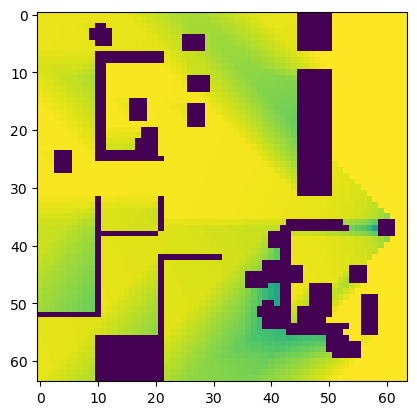

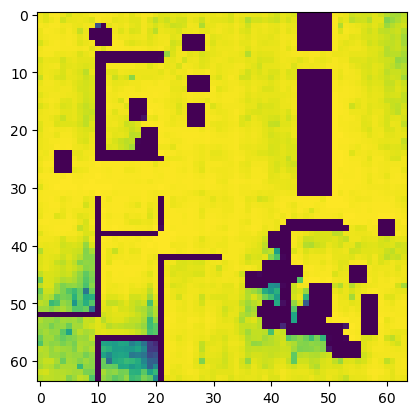

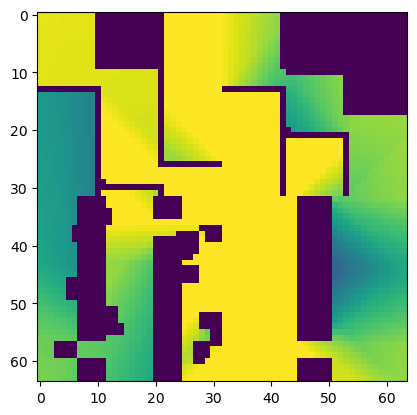

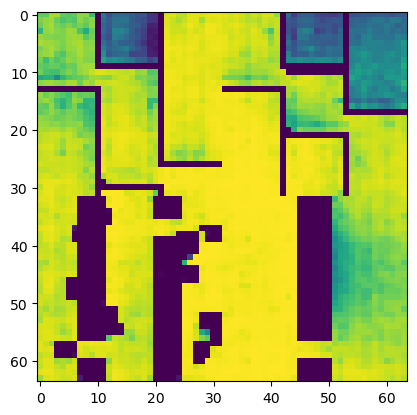

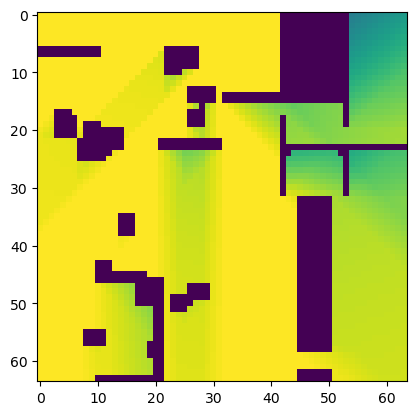

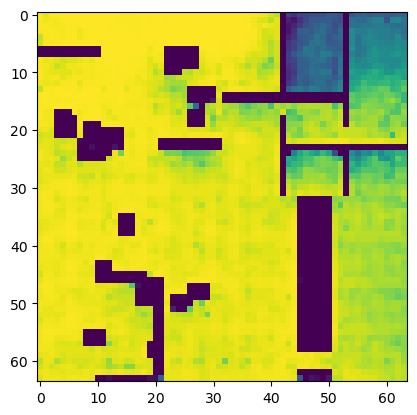

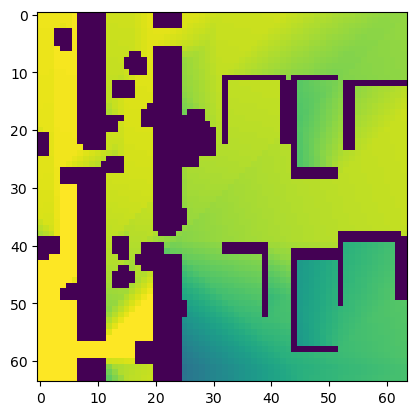

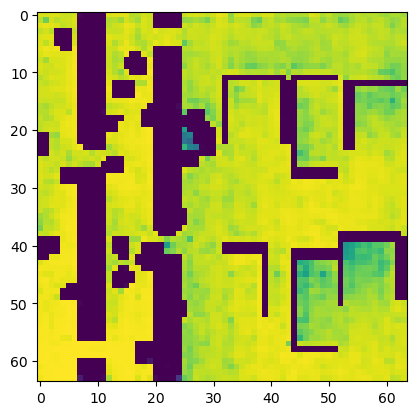

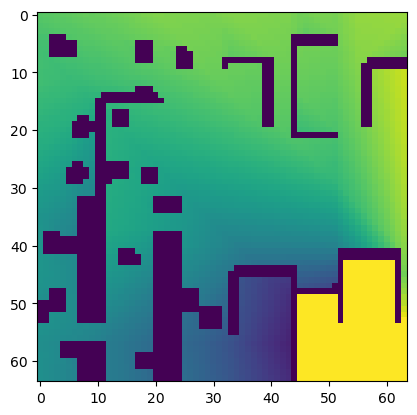

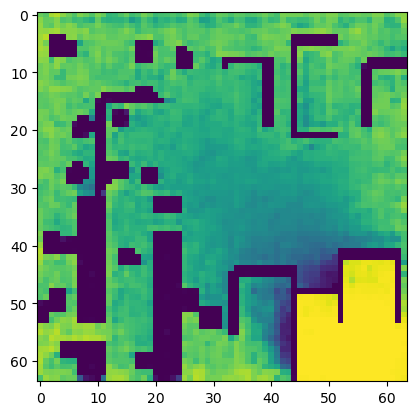

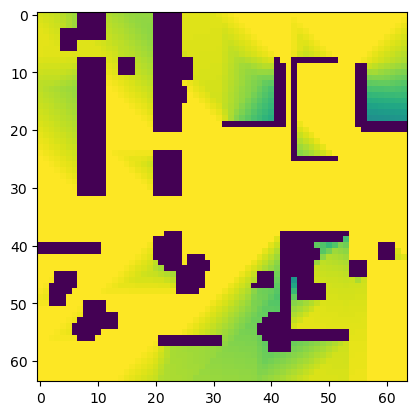

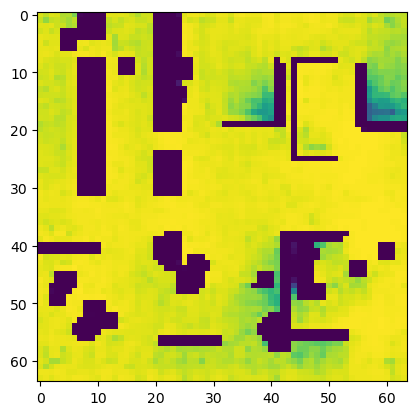

In [23]:
my_test_data = GridData(
        path=f'./TransPath_data/test',
        mode=mode
    )[indices]

map_design, start, goal, gt_hmap = my_test_data
inputs = torch.cat([map_design, start + goal], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goal], dim=1)
inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))
with torch.no_grad():
    predictions = (eval_model(inputs) + 1) / 2

for i in range(len(indices)):
    plt.imshow(gt_hmap[i, 0])
    plt.show()
    plt.imshow(predictions[i, 0].cpu().detach().numpy())
    plt.show()